# Please upload part1.zip

In [19]:
from google.colab import files
uploaded = files.upload()

Saving partI.zip to partI (1).zip


In [44]:
import zipfile
with zipfile.ZipFile('partI.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [45]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


# Here i only get  the images folder and gt and sort the content of both as Cars0.npy  the crossponding one for it Cars0.png 

In [46]:
npy_path = "/content/partI/nosol/gt"
images_path = "/content/partI/nosol/images"
npy = os.listdir(npy_path)
images = os.listdir(images_path)
npy_sorted = np.sort(npy)
images_sorted = np.sort(images)

In [47]:
def dlt(points,points_crosspond):
  
  N = points.shape[0]
  A = np.zeros((2 * N, 9))  ## 8*9
  for i in range(N):
      x, y = points[i]
      x_dash, y_dash = points_crosspond[i]
      A[2 * i, :] = [-x, -y, -1, 0, 0, 0, x_dash * x, x_dash * y, x_dash]
      A[2 * i + 1, :] = [0, 0, 0,- x, -y, -1, y_dash * x, y_dash * y, y_dash]
      U, D, Vt = np.linalg.svd(A)
      h = Vt[-1, :] / Vt[-1, -1]  # solution is last column of v divide it by h33 because we estimate homogrphy up to s scale
      homography = h.reshape(3, 3)
  
  return homography



# DLT and applying the resulting homograph to perform perspective correction to license plates, and compute mean squared error to the provided groundtruth homography

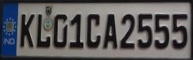

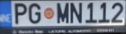

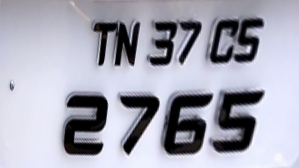

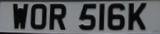

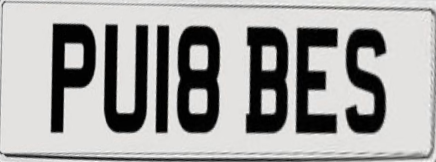

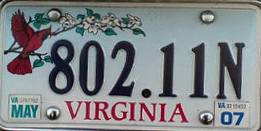

Total Mean Squared Error:  410.9712785802038


In [48]:

error = 0
for i in range(len(npy_sorted)):
    image = cv2.imread(os.path.join(images_path, images_sorted[i]))
    gt = np.load(os.path.join(npy_path, npy_sorted[i]), allow_pickle=True).item()
    points = gt['points']
    homography_gt = gt['homography']
    max_point = np.max(points, axis=0)
    min_point = np.min(points, axis=0)
    width, height = max_point[0] - min_point[0], max_point[1] - min_point[1]
    points_crosspond = np.array([[0, 0], [width, 0], [width, height],[0, height]])
    # TODO: Call your DLT methods according to norm flag
    homography = dlt(points,points_crosspond)
  
   
  

    output_image = cv2.warpPerspective(image,homography , (width, height))

    cv2_imshow( output_image)

  

    error += np.linalg.norm(homography.flatten() - homography_gt.flatten())**2
          
print('Total Mean Squared Error: ', error/len(npy_sorted))
   



# normalized DLT version Algorithm and applying the resulting homograph to perform perspective correction to license plates, and compute mean squared error to the provided groundtruth homography

In [49]:
def normalized_points(points):
  mean, std = np.mean(points, 0), np.std(points)

    # similarity transformation
    # set centroid as origin
  Transformation = np.array([[std/np.sqrt(2), 0, mean[0]],
                               [0, std/np.sqrt(2), mean[1]],
                               [0,   0, 1]])# s/s=1

    # apply transformation on data points
  points_1col= np.concatenate((points, np.ones((4, 1))), axis=1)# add column with ones to be applicable to apply tranformation to it 4*3   3*3
  points_normalized= np.dot(points_1col, Transformation)
  points_normalized = np.delete(points_normalized, -1, axis=1)# remove the added column 1
  return points_normalized,Transformation

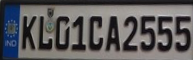

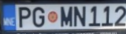

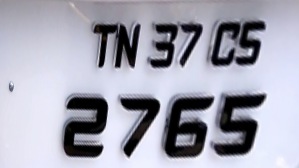

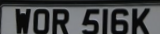

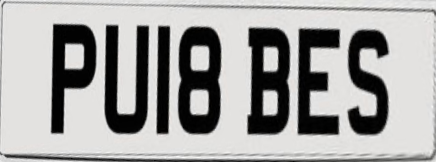

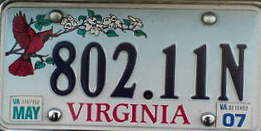

Total Mean Squared Error:  293.4108531598307


In [50]:
error1=0
for i in range(len(npy_sorted)):
    image = cv2.imread(os.path.join(images_path, images_sorted[i]))
    gt = np.load(os.path.join(npy_path, npy_sorted[i]), allow_pickle=True).item()
    points = gt['points']
    homography_gt = gt['homography']
    
    points_normalized,Transformation=normalized_points(points)# normalization of points
    
    max_point = np.max(points, axis=0)
    
    min_point = np.min(points, axis=0)

    width, height = max_point[0] - min_point[0], max_point[1] - min_point[1]
    
    points_crosspond = np.array([[0, 0], [width, 0], [width, height],[0, height]])
    
    points_crosspond_normalized,Transformation_crosspond=normalized_points(points_crosspond)# normalization of crossponding points 
    
    h = dlt(points_normalized,points_crosspond_normalized) # apply dlt
    
    inv_Trasformation_crosspond=np.linalg.inv(Transformation_crosspond)
    H_denormalized = np.dot(inv_Trasformation_crosspond, np.dot(h, Transformation))  # denormalization set H= T_dash_iverse * H * T

    
    error1 += np.linalg.norm(H_denormalized.flatten() - homography_gt.flatten())**2

    output_image1= cv2.warpPerspective(image,H_denormalized , (width, height))

    cv2_imshow(output_image1)


  

    
print('Total Mean Squared Error: ', error1/len(npy_sorted))



#I experimented with a different method to calculate corresponding points in order to minimize error, and it was successful.

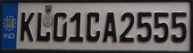

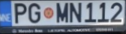

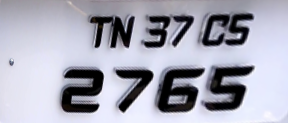

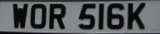

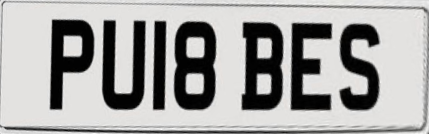

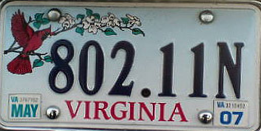

Total Mean Squared Error:  0.21409492135480532


In [52]:
error = 0
for i in range(len(npy_sorted)):
    image = cv2.imread(os.path.join(images_path, images_sorted[i]))
    gt = np.load(os.path.join(npy_path, npy_sorted[i]), allow_pickle=True).item()
    points = gt['points']
    homography_gt = gt['homography']
   
  
    width1=np.sqrt((points[0][0]-points[1][0])**2+(points[0][1]-points[1][1])**2)
    height1=np.sqrt((points[0][0]-points[3][0])**2+(points[0][1]-points[3][1])**2)
    width2=np.sqrt((points[2][0]-points[3][0])**2+(points[2][1]-points[3][1])**2)
    height2=np.sqrt((points[1][0]-points[2][0])**2+(points[1][1]-points[2][1])**2)
    maximum_w = max(width1, width2)
    maximum_h=max(height1, height2)
    proints2 = np.array([[0, 0], [maximum_w-1, 0],[maximum_w-1,maximum_h-1],[0, maximum_h-1]])
    

    homography = dlt(points,proints2)
  
   
  

    output_image = cv2.warpPerspective(image,homography , (int(maximum_w), int(maximum_h)))

    cv2_imshow( output_image)
  

    error += np.linalg.norm(homography.flatten() - homography_gt.flatten())**2
          
print('Total Mean Squared Error: ', error/len(npy_sorted))

# Applying the new way to normalized DLT

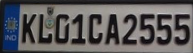

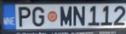

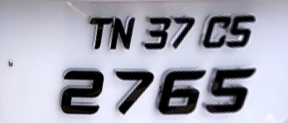

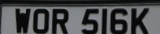

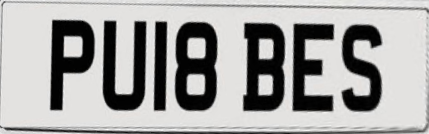

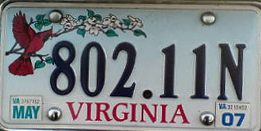

Total Mean Squared Error:  25.733615079519414


In [53]:
error1=0
for i in range(len(npy_sorted)):
    image = cv2.imread(os.path.join(images_path, images_sorted[i]))
    gt = np.load(os.path.join(npy_path, npy_sorted[i]), allow_pickle=True).item()
    points = gt['points']
    homography_gt = gt['homography']
    
    points_normalized,Transformation=normalized_points(points)# normalization of points
    
    width1=np.sqrt((points[0][0]-points[1][0])**2+(points[0][1]-points[1][1])**2)
    height1=np.sqrt((points[0][0]-points[3][0])**2+(points[0][1]-points[3][1])**2)
    width2=np.sqrt((points[2][0]-points[3][0])**2+(points[2][1]-points[3][1])**2)
    height2=np.sqrt((points[1][0]-points[2][0])**2+(points[1][1]-points[2][1])**2)
    maximum_w = max(width1, width2)
    maximum_h=max(height1, height2)
    proints2 = np.array([[0, 0], [maximum_w-1, 0],[maximum_w-1,maximum_h-1],[0, maximum_h-1]])
    points = np.array(points, dtype=np.float32)
    proints2 = np.array(proints2, dtype=np.float32)

    
    points_crosspond_normalized,Transformation_crosspond=normalized_points(proints2)# normalization of crossponding points 
    
    h = dlt(points_normalized,points_crosspond_normalized) # apply dlt
    
    inv_Trasformation_crosspond=np.linalg.inv(Transformation_crosspond)
    H_denormalized = np.dot(inv_Trasformation_crosspond, np.dot(h, Transformation))  # denormalization set H= T_dash_iverse * H * T

    
    error1 += np.linalg.norm(H_denormalized.flatten() - homography_gt.flatten())**2

    output_image1= cv2.warpPerspective(image,H_denormalized , (int(maximum_w), int(maximum_h)))

    cv2_imshow(output_image1)


  

    
print('Total Mean Squared Error: ', error1/len(npy_sorted))



In [56]:
%%shell
jupyter nbconvert --to html /content/Assignment_2_Part1_CV.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

CalledProcessError: ignored